# Lambda vs Omega Knowledge in Robotics
This notebook seeks to use topic modeling over a corpus of abstracts robotics paper abstracs to explore a potential relationship between theoretical and practical knowledge in the robotics field and scientific communities generally. Current implementation uses arxiv documents but I hope to use IROS and ICRA abstracts for a more representative picture of the field.

I took lots of code from https://www.kaggle.com/aiswaryaramachandran/exploring-the-growth-in-ai-using-arxiv/data?select=arxiv-metadata-oai-snapshot.json
and from https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2

In [41]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import sys
import ast

import plotly.express as px

import nltk
from nltk.corpus import stopwords
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity


# import networkx
# from networkx.algorithms.components.connected import connected_components

import json
import dask.bag as db




In [24]:
import utils

# Extracting Robotics Papers from Arxiv Repo

In [12]:
ai_category_list=['cs.RO']
records=db.read_text("*.json").map(lambda x:json.loads(x))
ai_docs = (records.filter(lambda x:any(ele in x['categories'] for ele in ai_category_list)==True))
get_metadata = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'],
                  'abstract':x['abstract'],
                 'version':x['versions'][-1]['created'],
                         'doi':x["doi"],
                         'authors_parsed':x['authors_parsed']}

data=ai_docs.map(get_metadata).to_dataframe().compute()

data.to_excel("AI_ML_ArXiv_Papers.xlsx",index=False,encoding="utf-8")

In [13]:
print("Number of Papers Related to Robotics is ",data.shape[0])

Number of Papers Related to AI and ML is  11726


In [14]:
data.head()

,id,title,category,abstract,version,doi,authors_parsed
0,0704.3268,2D Path Solutions from a Single Layer Excitabl...,cs.RO cs.NE,An easily implementable path solution algori...,"Tue, 24 Apr 2007 20:20:46 GMT",None,"[[Karahaliloglu, Koray, ]]"
1,0705.0738,The Optimization of a Novel Prismatic Drive,cs.RO,The design of a mechanical transmission taki...,"Sat, 5 May 2007 10:28:22 GMT",None,"[[Chablat, Damien, , IRCCyN], [Caro, Stéphane,..."
2,0705.0856,The Multiobjective Optimization of a Prismatic...,cs.RO,The multiobjective optimization of Slide-o-C...,"Mon, 7 May 2007 06:39:17 GMT",None,"[[Bouyer, Emilie, , IRCCyN], [Caro, Stéphane, ..."
3,0705.0956,On Isotropic Sets of Points in the Plane. Appl...,cs.RO,Various performance indices are used for the...,"Mon, 7 May 2007 18:19:06 GMT",None,"[[Angeles, Jorge, , CIM], [Chablat, Damien, , ..."
4,0705.0959,The Kinematic Analysis of a Symmetrical Three-...,cs.RO,Presented in this paper is the kinematic ana...,"Mon, 7 May 2007 18:28:17 GMT",None,"[[Chablat, Damien, , IRCCyN], [Wenger, Philipp..."


The data contains the id, the title,the category the paper belongs to, the date when the version was created and list of authors 

# Data Preprocessing

Some preprocessing steps that we need to perform are:

1. Extract the Date Time information from version column


2. The authors parsed information, first and last names need to be concatenated to get one name.

3. Handling Missing DOI's

4. We need to look for any possible duplication in the title names


### Extracting the Date Time Information

In [19]:
data['DateTime']=pd.to_datetime(data['version'])
data.head()

,id,title,category,abstract,version,doi,authors_parsed,DateTime
0,0704.3268,2D Path Solutions from a Single Layer Excitabl...,cs.RO cs.NE,An easily implementable path solution algori...,"Tue, 24 Apr 2007 20:20:46 GMT",None,"[[Karahaliloglu, Koray, ]]",2007-04-24 20:20:46+00:00
1,0705.0738,The Optimization of a Novel Prismatic Drive,cs.RO,The design of a mechanical transmission taki...,"Sat, 5 May 2007 10:28:22 GMT",None,"[[Chablat, Damien, , IRCCyN], [Caro, Stéphane,...",2007-05-05 10:28:22+00:00
2,0705.0856,The Multiobjective Optimization of a Prismatic...,cs.RO,The multiobjective optimization of Slide-o-C...,"Mon, 7 May 2007 06:39:17 GMT",None,"[[Bouyer, Emilie, , IRCCyN], [Caro, Stéphane, ...",2007-05-07 06:39:17+00:00
3,0705.0956,On Isotropic Sets of Points in the Plane. Appl...,cs.RO,Various performance indices are used for the...,"Mon, 7 May 2007 18:19:06 GMT",None,"[[Angeles, Jorge, , CIM], [Chablat, Damien, , ...",2007-05-07 18:19:06+00:00
4,0705.0959,The Kinematic Analysis of a Symmetrical Three-...,cs.RO,Presented in this paper is the kinematic ana...,"Mon, 7 May 2007 18:28:17 GMT",None,"[[Chablat, Damien, , IRCCyN], [Wenger, Philipp...",2007-05-07 18:28:17+00:00


In [45]:
import datetime
data['Year'] = data['DateTime'].dt.year
data['Date'] = data['DateTime'].dt.date
#data=utils.extractDateFeatures(data,"DateTime")
data.head()

,id,title,category,abstract,version,doi,authors_parsed,DateTime,num_authors,authors,Year,Date
0,0704.3268,2D Path Solutions from a Single Layer Excitabl...,cs.RO cs.NE,An easily implementable path solution algori...,"Tue, 24 Apr 2007 20:20:46 GMT",None,"[[Karahaliloglu, Koray, ]]",2007-04-24 20:20:46+00:00,1,[Karahaliloglu Koray],2007,2007-04-24
1,0705.0738,The Optimization of a Novel Prismatic Drive,cs.RO,The design of a mechanical transmission taki...,"Sat, 5 May 2007 10:28:22 GMT",None,"[[Chablat, Damien, , IRCCyN], [Caro, Stéphane,...",2007-05-05 10:28:22+00:00,3,"[Chablat Damien IRCCyN, Caro Stéphane IRCCyN...",2007,2007-05-05
2,0705.0856,The Multiobjective Optimization of a Prismatic...,cs.RO,The multiobjective optimization of Slide-o-C...,"Mon, 7 May 2007 06:39:17 GMT",None,"[[Bouyer, Emilie, , IRCCyN], [Caro, Stéphane, ...",2007-05-07 06:39:17+00:00,4,"[Bouyer Emilie IRCCyN, Caro Stéphane IRCCyN,...",2007,2007-05-07
3,0705.0956,On Isotropic Sets of Points in the Plane. Appl...,cs.RO,Various performance indices are used for the...,"Mon, 7 May 2007 18:19:06 GMT",None,"[[Angeles, Jorge, , CIM], [Chablat, Damien, , ...",2007-05-07 18:19:06+00:00,2,"[Angeles Jorge CIM, Chablat Damien IRCCyN]",2007,2007-05-07
4,0705.0959,The Kinematic Analysis of a Symmetrical Three-...,cs.RO,Presented in this paper is the kinematic ana...,"Mon, 7 May 2007 18:28:17 GMT",None,"[[Chablat, Damien, , IRCCyN], [Wenger, Philipp...",2007-05-07 18:28:17+00:00,2,"[Chablat Damien IRCCyN, Wenger Philippe IRCCyN]",2007,2007-05-07


### Cleaning the ***authors_parsed*** column


1. Concatenating the authors first and last names.

In [26]:
data['num_authors']=data['authors_parsed'].apply(lambda x:len(x))

In [27]:
data['authors']=data['authors_parsed'].apply(lambda authors:[(" ".join(author)).strip() for author in authors])
data.head()

,id,title,category,abstract,version,doi,authors_parsed,DateTime,num_authors,authors
0,0704.3268,2D Path Solutions from a Single Layer Excitabl...,cs.RO cs.NE,An easily implementable path solution algori...,"Tue, 24 Apr 2007 20:20:46 GMT",None,"[[Karahaliloglu, Koray, ]]",2007-04-24 20:20:46+00:00,1,[Karahaliloglu Koray]
1,0705.0738,The Optimization of a Novel Prismatic Drive,cs.RO,The design of a mechanical transmission taki...,"Sat, 5 May 2007 10:28:22 GMT",None,"[[Chablat, Damien, , IRCCyN], [Caro, Stéphane,...",2007-05-05 10:28:22+00:00,3,"[Chablat Damien IRCCyN, Caro Stéphane IRCCyN..."
2,0705.0856,The Multiobjective Optimization of a Prismatic...,cs.RO,The multiobjective optimization of Slide-o-C...,"Mon, 7 May 2007 06:39:17 GMT",None,"[[Bouyer, Emilie, , IRCCyN], [Caro, Stéphane, ...",2007-05-07 06:39:17+00:00,4,"[Bouyer Emilie IRCCyN, Caro Stéphane IRCCyN,..."
3,0705.0956,On Isotropic Sets of Points in the Plane. Appl...,cs.RO,Various performance indices are used for the...,"Mon, 7 May 2007 18:19:06 GMT",None,"[[Angeles, Jorge, , CIM], [Chablat, Damien, , ...",2007-05-07 18:19:06+00:00,2,"[Angeles Jorge CIM, Chablat Damien IRCCyN]"
4,0705.0959,The Kinematic Analysis of a Symmetrical Three-...,cs.RO,Presented in this paper is the kinematic ana...,"Mon, 7 May 2007 18:28:17 GMT",None,"[[Chablat, Damien, , IRCCyN], [Wenger, Philipp...",2007-05-07 18:28:17+00:00,2,"[Chablat Damien IRCCyN, Wenger Philippe IRCCyN]"


### Missing DOI 

In the Data, we can see that there are papers with no doi - Since Arxiv is a pre-print server, once the paper is published DOI is received. This DOI needs to be updated to Arxiv. In cases where there are no DOI - probably they were not published in any other journal or the author forgot to update the doi - hence there is no DOI available

(Reference : https://academia.stackexchange.com/questions/62480/why-does-arxiv-org-not-assign-dois)

In [17]:
print("Number of Papers with No DOI ",data[pd.isnull(data['doi'])].shape[0])

Number of Papers with No DOI  9921


Aroung 88% of the papers have no DOI - the authors most probably didnt update this information. 

# Analysing the Data

1. How has the field of ML/AI grown over the years?

2. Who have been the most successful Authors?

3. What are the different topics being spoken about  - and how this has changed over the years?

4. Can we cluster papers based on their Abstract and Title? 

## Growth in Field of ML AI 

In [43]:

papers_over_years=data.groupby(['Year']).size().reset_index().rename(columns={0:'Number Of Papers Published'})
px.line(x="Year",y="Number Of Papers Published",data_frame=papers_over_years,title="Growth of Robotics over the Years")

From 2010, there has been an exponential growth in this field - and this is continuously increasing over the period of time

In [46]:
papers_published_over_days=data.groupby(['Date']).size().reset_index().rename(columns={0:'Papers Published By Date'})
px.line(x="Date",y="Papers Published By Date",data_frame=papers_published_over_days,title="Average Papers Published Over Each Day")

From one published paper over each day, in the last one year there have been around 100 papers published each day. In Mar2013, there is a jump in number of papers published. Also, 2013 was the year, when the paper on Word2Vec was published - this was a new beginning in the field of NLP

## Who has published most papers in AI ML Space

In [53]:
ai_authors=pd.DataFrame(data['authors'].tolist()).rename(columns={0:'authors'})
papers_by_authors=ai_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False).head(20)
px.bar(x="Number of Papers Published",y="authors",data_frame=papers_by_authors.sort_values("Number of Papers Published",ascending=True),title="Top 20 Popular Authors",orientation="h")

In [52]:
np.shape(data['authors'].tolist())

/home/zach/anaconda3/envs/data_science/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(11726,)

In [55]:
# import nltk library and then download stopwords
import nltk 
nltk.download('stopwords')
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


[nltk_data] Downloading package stopwords to /home/zach/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [57]:
abstract_data = list(data.abstract)
abstract_data[:2]

['  An easily implementable path solution algorithm for 2D spatial problems,\nbased on excitable/programmable characteristics of a specific cellular\nnonlinear network (CNN) model is presented and numerically investigated. The\nnetwork is a single layer bioinspired model which was also implemented in CMOS\ntechnology. It exhibits excitable characteristics with regionally bistable\ncells. The related response realizes propagations of trigger autowaves, where\nthe excitable mode can be globally preset and reset. It is shown that, obstacle\ndistributions in 2D space can also be directly mapped onto the coupled cell\narray in the network. Combining these two features, the network model can serve\nas the main block in a 2D path computing processor. The related algorithm and\nconfigurations are numerically experimented with circuit level parameters and\nperformance estimations are also presented. The simplicity of the model also\nallows alternative technology and device level implementation,

In [58]:
stop_words = nltk.corpus.stopwords.words('english')

In [74]:
# Build the bigram and trigrams
bigram = gensim.models.Phrases(abstract_data, min_count=20, threshold=100) 
trigram = gensim.models.Phrases(bigram[abstract_data], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [75]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])


In [76]:
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []

    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [77]:
data_ready = process_words(abstract_data)

In [78]:
data_ready[0]

['easily',
 'implementable',
 'path',
 'solution',
 'algorithm',
 'spatial',
 'problem',
 'base',
 'excitable',
 'programmable',
 'characteristic',
 'specific',
 'cellular',
 'nonlinear',
 'network',
 'present',
 'numerically',
 'investigate',
 'network',
 'single',
 'layer',
 'bioinspire',
 'model',
 'also',
 'implement',
 'cmo',
 'technology',
 'exhibit',
 'excitable',
 'characteristic',
 'regionally',
 'bistable',
 'cell',
 'related',
 'response',
 'realize',
 'propagation',
 'autowave',
 'excitable',
 'mode',
 'globally',
 'preset',
 'reset',
 'show',
 'obstacle',
 'distribution',
 'space',
 'also',
 'directly',
 'map',
 'couple',
 'cell',
 'array',
 'network',
 'combine',
 'feature',
 'network',
 'model',
 'serve',
 'main',
 'block',
 'path',
 'compute',
 'processor',
 'relate',
 'algorithm',
 'configuration',
 'numerically',
 'experiment',
 'circuit',
 'level',
 'parameter',
 'performance',
 'estimation',
 'also',
 'present',
 'simplicity',
 'model',
 'also',
 'allow',
 'alternat

In [79]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 16852


In [81]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus

[[(0, 2),
  (1, 1),
  (2, 4),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 2),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 3),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 3),
  (45, 1),
  (46, 4),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 1),
  (56, 2),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 2),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2)],
 [(4, 1),
  (8, 1),
  (23, 1),
  (52, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 4),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 2),
  (87, 1),

In [82]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq

In [83]:
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/home/zach/anaconda3/envs/data_science/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



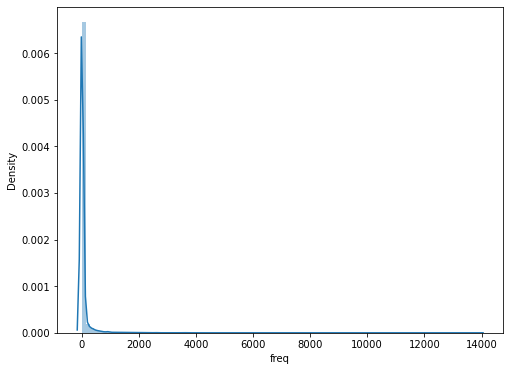

In [84]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [85]:
dict_df.sort_values('freq', ascending=False).head(10)

,freq
use,13899
robot,12458
model,9693
system,9606
propose,9026
base,8767
method,8669
task,7666
approach,7098
learn,7004


In [86]:
extension = dict_df[dict_df.freq>1500].index.tolist()
extension

['algorithm',
 'allow',
 'also',
 'application',
 'autonomous',
 'base',
 'design',
 'estimation',
 'experiment',
 'feature',
 'level',
 'map',
 'model',
 'network',
 'parameter',
 'path',
 'performance',
 'present',
 'problem',
 'robotic',
 'show',
 'solution',
 'space',
 'drive',
 'introduce',
 'motion',
 'multiple',
 'paper',
 'provide',
 'robot',
 'evaluate',
 'function',
 'number',
 'optimization',
 'use',
 'condition',
 'consider',
 'low',
 'method',
 'point',
 'set',
 'exist',
 'make',
 'planning',
 'give',
 'image',
 'new',
 'study',
 'well',
 'work',
 'control',
 'different',
 'first',
 'large',
 'optimal',
 'result',
 'dynamic',
 'high',
 'accuracy',
 'develop',
 'end',
 'however',
 'include',
 'many',
 'need',
 'require',
 'task',
 'propose',
 'approach',
 'demonstrate',
 'estimate',
 'novel',
 'system',
 'technique',
 'test',
 'constraint',
 'process',
 'compare',
 'complex',
 'detection',
 'object',
 'order',
 'position',
 'find',
 'perform',
 'solve',
 'efficient',
 'user

In [87]:
stop_words.extend(extension)

In [88]:
data_ready = process_words(abstract_data)

In [89]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 17001


In [90]:
# Filter out words that occur less than 10 documents, or more than 50% of the documents.

id2word.filter_extremes(no_below=10, no_above=0.5)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 4337


In [91]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [95]:
mallet_path = '/home/zach/mallet-2.0.8/bin/mallet'

In [96]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [97]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('structure', 0.020514161220043573),
   ('configuration', 0.019450980392156862),
   ('joint', 0.015006535947712419),
   ('error', 0.014431372549019607),
   ('analysis', 0.014396514161220043),
   ('obtain', 0.01427450980392157),
   ('linear', 0.014135076252723311),
   ('manipulator', 0.013368191721132898),
   ('property', 0.01281045751633987),
   ('velocity', 0.012688453159041393)]),
 (1,
  [('field', 0.020922598479612992),
   ('area', 0.017553559087767796),
   ('aerial', 0.01434001382170007),
   ('small', 0.01326883206634416),
   ('operation', 0.01326883206634416),
   ('platform', 0.011541119557705598),
   ('increase', 0.01121285418106427),
   ('flight', 0.01065998617829993),
   ('potential', 0.01065998617829993),
   ('event', 0.010435383552176918)]),
 (2,
  [('prediction', 0.02371816019307902),
   ('uncertainty', 0.02232910249509489),
   ('term', 0.021304672442831595),
   ('safety', 0.021304672442831595),
   ('predict', 0.021304672442831595),
   ('decision', 0.0195509870991266

In [98]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.4951891060502369


## Analyse the Papers published by Bengio Yoshua 

Bengio Yoshua, is well known for his work on Artifical Neural Networks and Deep Learning. Bengio along with Geoffrey Hinton and Yann LeCun are reffered to as the "Godfathers of AI". Let us look at what kind of research Bengio has been involved him and understand his contributions to this field - that led him to win the Turing Award


In [54]:
data['is_bengio_author']=data['authors'].apply(lambda x:1 if "Bengio Yoshua" in x else 0)
bengio_papers=data[data['is_bengio_author']==1]
bengio_papers=bengio_papers.reset_index(drop=True)

print("Number of Papers by Bengio Yoshua on Arxiv is ",bengio_papers.shape[0])

Number of Papers by Bengio Yoshua on Arxiv is  2


In [ ]:
print("Bengio Yoshua Published His First Paper in ",min(bengio_papers['Date']))
print("Bengio Yoshua Published His Recent Paper in ",max(bengio_papers['Date']))


Though Bengio, had entered the field of AI ML in the 1990's the first paper published by him on Arxiv is in September of 2010 and his most recent paper is in August 2020. In 10 years, he has published 311 papers - Astounding Rate of Publication. It may be possible that his other papers are tagged into other categories on Arxiv that we are not considering for this analysis

In [ ]:
bengio_papers_by_year=bengio_papers.groupby(['Year']).size().reset_index().rename(columns={0:'Number of Papers Published'})

px.bar(x="Year",y="Number of Papers Published",title="Papers by Bengio Yoshua Over Years",data_frame=bengio_papers_by_year)

In [ ]:
print("Average Papers Published in a Year By Bengio Yoshua ",np.median(bengio_papers_by_year['Number of Papers Published']))


###  What are the topics in which Bengio Yoshua has published papers in?

To look at topics at a broad level, we can Build a Frequency Bar Plot to understand key words used in the titles of the papers published.

Before we look at the top words in the Title, we will have to do some cleaning of the title - Removing Stop Words, Lower Casing the Words. Let us not do any stemming or lemmatization

In [ ]:
titles=data['title'].tolist()
stop_words = set(stopwords.words('english')) 
titles=[title.lower() for title in titles] ### Lower Casing the Title
titles=[utils.removeStopWords(title,stop_words) for title in titles]

In [ ]:

bigrams_list=[" ".join(utils.generateNGram(title,2)) for title in titles]
topn=50
top_bigrams=utils.getMostCommon(bigrams_list,topn=topn)
top_bigrams_df=pd.DataFrame()
top_bigrams_df['words']=[val[0] for val in top_bigrams]
top_bigrams_df['Frequency']=[val[1] for val in top_bigrams]
px.bar(data_frame=top_bigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Bigrams in Papers by Bengio Yoshua")

In [ ]:
trigrams_list=[" ".join(utils.generateNGram(title.replace(":",""),3)) for title in titles]
topn=50
top_trigrams=utils.getMostCommon(trigrams_list,topn=topn)
top_trigrams_df=pd.DataFrame()
top_trigrams_df['words']=[val[0] for val in top_trigrams]
top_trigrams_df['Frequency']=[val[1] for val in top_trigrams]
top_trigrams_df=top_trigrams_df[top_trigrams_df["words"]!=""]
px.bar(data_frame=top_trigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Trigrams in Papers by Bengio Yoshua")

As we can there has been a lot of Papers on Recurrent Neural Networks and Reinforcement Learning by Bengio Yoshua. Also, his research areas are also focussed on Neural Machine Translations and Understanding Stochastic Gradients. The top words also, show us that Bengio has worked on various topics in Deep Learning as part of his research - The next question arises is can we categorise his work? And also can we see who are the authors he works predominantly with for each of the categories we have identified

### Topic Modelling to Understand Different Themes


In [ ]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

In [ ]:
'''
The tokenise function will lowercase, and tokenise the sentences
'''

def tokenise(sentences):
    return [gensim.utils.simple_preprocess(sentence, deacc=True,max_len=50) for sentence in sentences]


In [ ]:
tokenised_sentences=tokenise(bengio_papers['title'].tolist())
tokenised_sentences[0]

In [ ]:
nlp = spacy.load('en')

In [ ]:
def lemmatise(sentence,stop_words,allowed_postags=None):
    doc=nlp(sentence)
    #print(sentence)
    if allowed_postags!=None:
        tokens = [token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.text not in stop_words)]
    if allowed_postags==None:
        tokens= [token.lemma_ for token in doc if (token.text not in stop_words)]
    return tokens

In [ ]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
sentences=[" ".join(tokenised_sentence) for tokenised_sentence in tokenised_sentences]
lemmatised_sentences=[lemmatise(sentence,stop_words) for sentence in sentences]
lemmatised_sentences[0]

#### Building Bigrams and Trigrams 

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(lemmatised_sentences,min_count=2) 
trigram = gensim.models.Phrases(bigram[lemmatised_sentences],min_count=2)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
bigrams_words=[bigram_mod[sentence] for sentence in lemmatised_sentences]

trigrams_words=[trigram_mod[sentence] for sentence in bigrams_words]


#### Creating Dictionary and Corpus 

In [ ]:
id2word = corpora.Dictionary(trigrams_words)
corpus = [id2word.doc2bow(text) for text in trigrams_words]
[(id2word[id], freq) for id, freq in corpus[0]] 

In [ ]:
def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
models,coherence=compute_coherence_values(id2word,corpus,trigrams_words,limit=20,start=2,step=2)
x = range(2, 20, 2)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Around 6 topics seem a good number

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=trigrams_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

There are topics related to GAN and adversial networks in relation to speech and images.There are topics related to hypergraph and Deep Reinforcement Learning as well.

Let us now assign, each document to a Topics - a document may consists of more than one topic, but we will assign it the dominant topic

In [ ]:
def format_topics_sentences(texts,ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)




In [ ]:
df_topic_sents_keywords = format_topics_sentences(bengio_papers['title'].tolist(),ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
topic_counts=df_dominant_topic['Dominant_Topic'].value_counts().reset_index().rename(columns={'index':'Topic','Dominant_Topic':'Number of Documents'})
topic_counts['percentage_contribution']=(topic_counts['Number of Documents']/topic_counts['Number of Documents'].sum())*100
topic_counts

We can see that number of documents is each topic is almost equally distributed.. Let us use T-SNE to visualise the topics vs document distribution


In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE


# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values


# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)



In [ ]:
sent_topics_df=pd.DataFrame()
sent_topics_df['Text']=bengio_papers['title'].tolist()
sent_topics_df['tsne_x']=tsne_lda[:,0]
sent_topics_df['tsne_y']=tsne_lda[:,1]
sent_topics_df['Topic_No']=topic_num
sent_topics_df=pd.merge(sent_topics_df,df_dominant_topic,on="Text")
sent_topics_df.head()

In [ ]:
px.scatter(x='tsne_x',y='tsne_y',data_frame=sent_topics_df,color="Topic_No",hover_data=["Topic_Perc_Contrib"])

The topics are very well seperated as we can see from TSNE

### Has Bengio Worked with Different Authors on Different Topics? Who is the most popular Co-Author across different topics?

In [ ]:
bengio_papers=pd.merge(bengio_papers,df_dominant_topic.rename(columns={'Text':'title'}),on='title')

num_topics=bengio_papers['Dominant_Topic'].nunique()
authors_df_list=[]

for topic_no in range(num_topics):
    

    temp=bengio_papers[bengio_papers['Dominant_Topic']==topic_no]
    authors=pd.DataFrame(utils.flattenList(temp['authors'].tolist())).rename(columns={0:'authors'})
    authors=authors[authors['authors']!="Bengio Yoshua"]
    papers_authors=authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False).head(10)
    papers_authors['Topic No']=topic_no
    authors_df_list.append(papers_authors)

co_occurring_authors=pd.concat(authors_df_list)


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
fig = make_subplots(rows=3, cols=2)
row=1
col=1
for topic_no in range(num_topics):
    
    wp = lda_model.show_topic(topic_no)
    topic_keywords = ", ".join([word for word, prop in wp])
    temp=co_occurring_authors.loc[co_occurring_authors['Topic No']==topic_no].sort_values("Number of Papers Published",ascending=True)

    fig.add_trace(
    go.Bar(
        x=temp['Number of Papers Published'],
        y=temp['authors'],
        orientation='h',
        name="Topic "+str(topic_no)
        #mode="markers+text",
        #text=["Text A", "Text B", "Text C"],
        #textposition="bottom center"
    ),
    row=row, col=col)
    if col%2==0:
        row=row+1
        col=1
    else:
        col=col+1
fig.update_layout(height=1000, width=1200, title_text="Top 10 Authors With Whom Bengio Worked Across Different Topics")

fig.show()



Across Topics, Bengio has published papers with Courville Aaron. The other authors are quite distinct across Topics.Courville Aaron is a part of LISA lab along with Bengiom. Except for Topic 2 which talks about self taught deep neural networks and causal networks, the top author with whom Bengio has published his papers with is Courville Aaraon

# Conclusion and Future Works

In this Analysis, we started off with analysing the set of AI and ML Papers in the Arxiv Repository. And then we explored the Worked of Bengio Yoshua. As a part of Future Work we can 

1. Use Abstract Information for more indepth topic Analysis
2. Can we build a co-citation network and analyse similar authors
3. We can build a Topic Model on Entire Dataset to understand how each topic has evolved over time